In [1]:
from glob import glob
import pandas as pd
import datetime
import plotly

from konlpy.tag import Twitter
from collections import Counter
from wordcloud import WordCloud
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def change_to_datetime(submit_string):
    year = submit_string.split('-')[0]
    month = submit_string.split('-')[1]
    day = submit_string.split('-')[2].split('T')[0]
    
    return datetime.datetime(int(year), int(month), int(day))

In [3]:
def draw_word_cloud(origin_df, start_date, end_date):
    
    query = origin_df[(origin_df.Date_Time >= start_date) & (origin_df.Date_Time <= end_date)]
    
    q1 = query[['Review Text', 'Date_Time']].dropna()
    q1.columns = ['Reviews', 'Date_Time']
    q2 = query[['Review Title', 'Date_Time']].dropna()    
    q2.columns = ['Reviews', 'Date_Time']
    
    q = q1.append(q2)
    q.index = range(len(q))
    
    q['preprocess'] = q.Reviews.apply(lambda text : " ".join(parser.morphs(text)))
    cnt = Counter(word for line in q.preprocess for word in line.split())
    print(len(q))
    
    font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
    wc = WordCloud(font_path=font_path, width=1280 , height=720, background_color="white").generate_from_frequencies(cnt)

    plt.figure(figsize=(16,9))
    plt.imshow(wc,interpolation='bilinear')
    plt.axis('off')
    plt.show()
    

In [4]:
parser = Twitter()
origin = pd.read_csv('./sample_201803.csv')
origin['Date_Time'] = origin['Review Submit Date and Time'].apply(lambda info_str: change_to_datetime(info_str))
origin = origin[['Review Text', 'Review Title', 'Date_Time']]
origin.index = range(len(origin))

/home/slayer/.pyenv/versions/3.6.5/envs/tftest/lib/python3.6/site-packages/konlpy/tag/_okt.py:16: UserWarning:

"Twitter" has changed to "Okt" since KoNLPy v0.4.5.



In [5]:
origin.head()

,Review Text,Review Title,Date_Time
0,NaN,NaN,2018-03-01
1,진짜좋군뇨,NaN,2018-03-01
2,모르는 문제 있으면 바로바로 앱으로 알수있어서 완전좋습니다조아요 풀이도 이해가기쉽게...,NaN,2018-03-01
3,진짜 좋은것 같아요!,NaN,2018-03-01
4,조..조아여,NaN,2018-03-01


2978


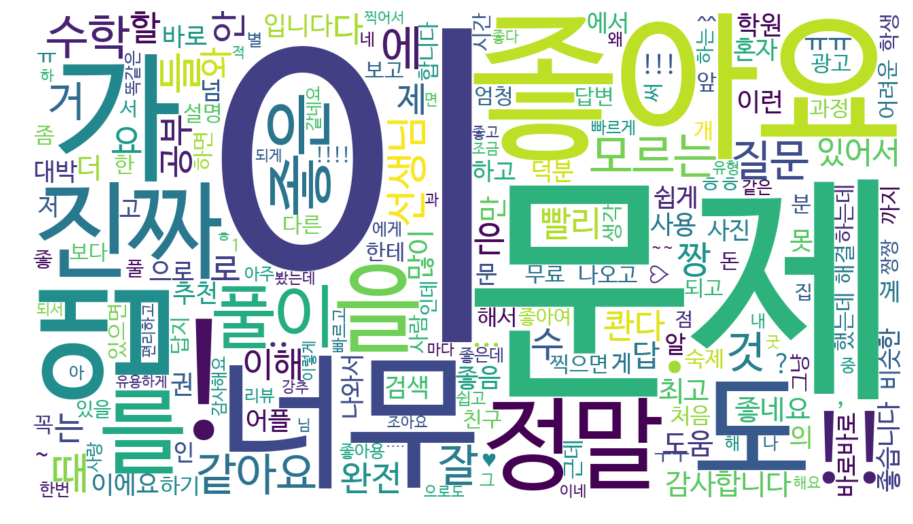

In [6]:
draw_word_cloud(origin, '2018-03-01', '2018-03-31')

### 좀 더 자세히 

In [9]:
import seaborn as sns
import numpy as np

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf").get_name()
rc('font', family=font_name)

In [11]:
def get_processed_data(origin_df, start_date, end_date):
    
    query = origin_df[(origin_df.Date_Time >= start_date) & (origin_df.Date_Time <= end_date)]

    q1 = query[['Review Text', 'Date_Time']].dropna()
    q1.columns = ['Reviews', 'Date_Time']
    q2 = query[['Review Title', 'Date_Time']].dropna()    
    q2.columns = ['Reviews', 'Date_Time']

    q = q1.append(q2)
    q.index = range(len(q))

    q['preprocess'] = q.Reviews.apply(lambda text : " ".join(parser.morphs(text)))
    cnt = Counter(word for line in q.preprocess for word in line.split())
    
    return q, cnt

In [12]:
query_1, counter_1 = get_processed_data(origin, '2018-03-01', '2018-03-10')
query_2, counter_2 = get_processed_data(origin, '2018-03-11', '2018-03-20')
query_3, counter_3 = get_processed_data(origin, '2018-03-21', '2018-03-31')

In [13]:
df = pd.DataFrame([counter_1, counter_2, counter_3]).T
df.columns = ['초기 10일', '중기 10일', '후기 10일']
df = df.apply(lambda x : x / np.sum(x))
df = df.apply(lambda x : (x-min(x)) / (max(x)-min(x)))
df = df.dropna()

###  마지막 10일 기준으로 정렬

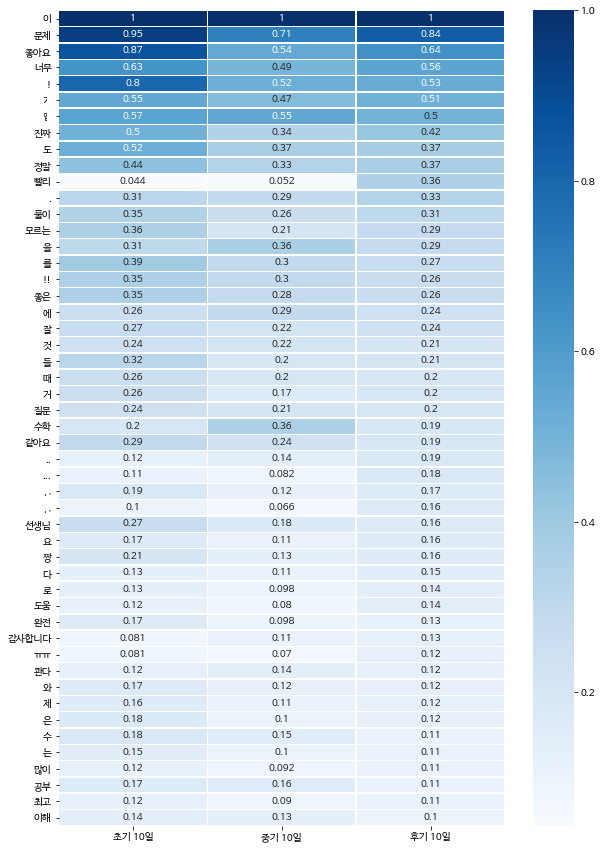

In [117]:
plt.figure(figsize=(10,15))
sns.heatmap(df.sort_values(df.columns[2], ascending=False).iloc[:50], annot=True, linewidths=0.5, cmap="Blues")

### Word2Vec 을 통해 키워드별 거리를 살펴보기


In [118]:
from gensim.models import Word2Vec

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [120]:
query, counter = get_processed_data(origin, '2011-08-01', '2018-10-10')

In [ ]:
embedding_model = Word2Vec([line.split() for line in query.preprocess], size=100, window=5, min_count=20, workers=4, iter=50, sg=1)

### potly 이용해서 시각화하기

In [54]:
import numpy as np
import plotly
plotly.tools.set_credentials_file(username='YOUR_NAME', api_key='YOUR_KEY')

from sklearn.manifold import TSNE

import plotly.plotly as py
import plotly.graph_objs as go

In [52]:
X = np.array([embedding_model.wv.get_vector(word) for word in embdding_model.wv.vocab.keys()])
voca = list(embdding_model.wv.vocab.keys())
X_embeded = TSNE(n_components=2).fit_transform(X)

In [55]:
trace2 = go.Scatter(
    x=[x for x, y in X_embeded],
    y=[y for x, y in X_embeded],
    mode='markers+text',
    name='Markers and Text',
    text=voca,
    textposition='bottom center'
)

data = [trace2]
layout = go.Layout(
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='text-chart-basic')